# Meat Elasticity Modelling

## Auth and package setup

In [116]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Authenticated
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
from google.cloud import bigquery
import pandas_gbq
import pandas as pd
import numpy as np
import sys
import os
import plotnine as p9
from mizani.formatters import currency_format

In [118]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


## Get data

In [119]:
# def bq_sql_mainData(lagDays=7):
#     query = """
#     #standardSQL
#     create temp table elastData_meat as (
#     with asp_dat as
#     (
#     SELECT
#     ifnull(SalesOrg,'') as SalesOrg,
#     ifnull(Site,'') as Site,
#     ifnull(Article,'') as Article,
#     ifnull(Article_Description,'') as Article_Description,
#     ifnull(Category_Description,'') as Category_Description,
#     ifnull(SubCategory_Description,'') as SubCategory_Description,
#     ifnull((case when Sales_Unit in ('CA1','CA2','CA3') then 'CAR' else Sales_Unit end),'') as Sales_Unit, Calendar_Day
#     , DATE_ADD(Calendar_Day, INTERVAL -{lagDays} DAY) as lag_Calendar_Day
#     , sum(Sales_ExclTax) as Sales_ExclTax
#     , sum(Sales_Qty_SUoM) as Sales_Qty_SUoM
#     , (case when sum(Sales_Qty_SUoM) = 0 then NULL else sum(Sales_ExclTax)/sum(Sales_Qty_SUoM) end) as ASP
#     , sum(Promo_Sales) as Promo_Sales
#     , sum(Promo_Sales_Qty_SUoM) as Promo_Sales_Qty_SUoM
#     FROM  `gcp-wow-ent-im-tbl-prod.gs_allgrp_fin_data.fin_group_profit_v`
#     WHERE
#     SalesOrg in ('1005') AND
#     Category_Description in ("MEAT","MEAT CONVENIENCE") AND
#     Calendar_Day between '2018-01-01' AND '2020-12-16'
#     group by ifnull(SalesOrg,''),
#     ifnull(Site,''),
#     ifnull(Article,''),
#     ifnull(Article_Description,''),
#     ifnull(Category_Description,''),
#     ifnull(SubCategory_Description,''),
#     ifnull((case when Sales_Unit in ('CA1','CA2','CA3') then 'CAR' else Sales_Unit end),''), Calendar_Day
#     )
#     select a.*,
#     a.Sales_ExclTax-b.Sales_ExclTax as Sales_ExclTax_diff,
#     a.Sales_Qty_SUoM-b.Sales_Qty_SUoM as Sales_Qty_SUoM_diff,
#     b.Sales_ExclTax as Sales_ExclTax_lag,
#     b.Sales_Qty_SUoM as Sales_Qty_SUoM_lag,
#     b.ASP as ASP_lag,
#     a.ASP-b.ASP as ASP_diff,
#     (case when b.ASP = 0 then null else a.ASP/b.ASP end) as ASP_v_lag,
#     (case when b.Sales_Qty_SUoM = 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) as Sales_Qty_SUoM_v_lag,
#     log(case when b.ASP = 0 then null
#     when a.ASP/b.ASP < 0 then null
#     else a.ASP/b.ASP end) as log_ASP_v_lag,
#     log(case when b.Sales_Qty_SUoM = 0 then null
#     when a.Sales_Qty_SUoM/b.Sales_Qty_SUoM < 0 then null
#     else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) as log_Sales_Qty_SUoM_v_lag,
#     (case when a.Sales_ExclTax = 0 then 0
#     when a.Promo_Sales/a.Sales_ExclTax > 1 then 1
#     else a.Promo_Sales/a.Sales_ExclTax
#     end) as promo_perc
#     from asp_dat a
#     left join (
#     SELECT *
#     from asp_dat
#     ) b
#     on (a.lag_Calendar_Day=b.Calendar_Day) AND
#     (a.SalesOrg = b.SalesOrg) and
#     (a.Site = b.Site) and
#     (a.Article=b.Article) AND
#     (a.Sales_Unit=b.Sales_Unit)
#     where
#     b.Sales_Qty_SUoM > 0 AND
#     b.Sales_Qty_SUoM is not null AND
#     (case when b.ASP = 0 then null else a.ASP/b.ASP end) between 0.25 and 4 AND
#     (case when b.ASP = 0 then null else a.ASP/b.ASP end) is not null AND
#     log(case when b.ASP = 0 then null when a.ASP/b.ASP < 0 then null else a.ASP/b.ASP end) is not null AND
#     log(case when b.Sales_Qty_SUoM = 0 then null when a.Sales_Qty_SUoM/b.Sales_Qty_SUoM < 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) is not null AND
#     (case when b.Sales_Qty_SUoM = 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) < 100 # remove non-sensicle perc growth
#     );

#     with dat as (
#     SELECT a.SalesOrg, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit,
#     (case when Calendar_Day <= '2020-02-01' then 'pre-covid' 
#     when Calendar_Day <= '2020-04-01' then 'covid (panic buying)'
#     else 'covid (Other)' end) as covid_flag,
#     avg(a.log_ASP_v_lag) as mean_x,
#     avg(a.log_Sales_Qty_SUoM_v_lag) as mean_y,
#     corr(a.log_ASP_v_lag, log_Sales_Qty_SUoM_v_lag) as corr_xy,
#     stddev(a.log_ASP_v_lag) as sd_x,
#     stddev(a.log_Sales_Qty_SUoM_v_lag) as sd_y,
#     sum(case when a.log_ASP_v_lag > 0.1 then 1 else 0 end) as cnt_overs,
#     sum(case when a.log_ASP_v_lag < -0.1 then 1 else 0 end) as cnt_unders,
#     avg(case when a.log_ASP_v_lag < -0.1 then 1 else 0 end) as perc_unders,
#     sum(Sales_ExclTax) as Sales_ExclTax,
#     sum(Sales_Qty_SUoM) as Sales_Qty_SUoM,
#     (case when sum(Sales_Qty_SUoM) = 0 then null else sum(Sales_ExclTax)/sum(Sales_Qty_SUoM) end) as ASP
#     FROM elastData_meat a
#     group by a.SalesOrg, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit, 
#     (case when Calendar_Day <= '2020-02-01' then 'pre-covid' 
#     when Calendar_Day <= '2020-04-01' then 'covid (panic buying)'
#     else 'covid (Other)' end)
#     )
#     select a.*,
#     a.corr_xy*a.sd_y/a.sd_x as slope,
#     a.mean_y-a.mean_x*(a.corr_xy*a.sd_y/a.sd_x) as y_intercept
#     from dat a
#     #where (ifnull(a.cnt_overs,0)+ifnull(a.cnt_unders,0))>=10
#     where ifnull(a.cnt_overs,0)>50 and ifnull(a.cnt_unders,0)>50
#     order by a.SalesOrg, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit;
#     """.format(lagDays=lagDays)
#     return query

# def run_bq(sql, client, location="US"):
#     query_job = client.query(sql, location=location)
#     # wait for query to run_bq
#     query_job.result()

# def get_bq_data(sql, project_id):
#     import pandas_gbq
#     return pandas_gbq.read_gbq(sql,
#                                project_id=project_id,
#                                use_bqstorage_api=True)


In [120]:
def bq_sql_mainData(lagDays=7):
    query = """
    #standardSQL
    create temp table elastData_meat as (
    with asp_dat as
    (
    SELECT
    ifnull(SalesOrg,'') as SalesOrg,
    ifnull(Site,'') as Site,
    ifnull(Article,'') as Article,
    ifnull(Article_Description,'') as Article_Description,
    ifnull(Category_Description,'') as Category_Description,
    ifnull(SubCategory_Description,'') as SubCategory_Description,
    ifnull((case when Sales_Unit in ('CA1','CA2','CA3') then 'CAR' else Sales_Unit end),'') as Sales_Unit, Calendar_Day
    , DATE_ADD(Calendar_Day, INTERVAL -{lagDays} DAY) as lag_Calendar_Day
    , sum(Sales_ExclTax) as Sales_ExclTax
    , sum(Sales_Qty_SUoM) as Sales_Qty_SUoM
    , (case when sum(Sales_Qty_SUoM) = 0 then NULL else sum(Sales_ExclTax)/sum(Sales_Qty_SUoM) end) as ASP
    , sum(Promo_Sales) as Promo_Sales
    , sum(Promo_Sales_Qty_SUoM) as Promo_Sales_Qty_SUoM
    FROM  `gcp-wow-ent-im-tbl-prod.gs_allgrp_fin_data.fin_group_profit_v`
    WHERE
    SalesOrg in ('1005') AND
    Category_Description in ("MEAT","MEAT CONVENIENCE") AND
    Calendar_Day between '2018-01-01' AND '2020-12-16'
    group by ifnull(SalesOrg,''),
    ifnull(Site,''),
    ifnull(Article,''),
    ifnull(Article_Description,''),
    ifnull(Category_Description,''),
    ifnull(SubCategory_Description,''),
    ifnull((case when Sales_Unit in ('CA1','CA2','CA3') then 'CAR' else Sales_Unit end),''), Calendar_Day
    )
    select a.*,
    a.Sales_ExclTax-b.Sales_ExclTax as Sales_ExclTax_diff,
    a.Sales_Qty_SUoM-b.Sales_Qty_SUoM as Sales_Qty_SUoM_diff,
    b.Sales_ExclTax as Sales_ExclTax_lag,
    b.Sales_Qty_SUoM as Sales_Qty_SUoM_lag,
    b.ASP as ASP_lag,
    a.ASP-b.ASP as ASP_diff,
    (case when b.ASP = 0 then null else a.ASP/b.ASP end) as ASP_v_lag,
    (case when b.Sales_Qty_SUoM = 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) as Sales_Qty_SUoM_v_lag,
    log(case when b.ASP = 0 then null
    when a.ASP/b.ASP < 0 then null
    else a.ASP/b.ASP end) as log_ASP_v_lag,
    log(case when b.Sales_Qty_SUoM = 0 then null
    when a.Sales_Qty_SUoM/b.Sales_Qty_SUoM < 0 then null
    else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) as log_Sales_Qty_SUoM_v_lag,
    (case when a.Sales_ExclTax = 0 then 0
    when a.Promo_Sales/a.Sales_ExclTax > 1 then 1
    else a.Promo_Sales/a.Sales_ExclTax
    end) as promo_perc
    from asp_dat a
    left join (
    SELECT *
    from asp_dat
    ) b
    on (a.lag_Calendar_Day=b.Calendar_Day) AND
    (a.SalesOrg = b.SalesOrg) and
    (a.Site = b.Site) and
    (a.Article=b.Article) AND
    (a.Sales_Unit=b.Sales_Unit)
    where
    b.Sales_Qty_SUoM > 0 AND
    b.Sales_Qty_SUoM is not null AND
    (case when b.ASP = 0 then null else a.ASP/b.ASP end) between 0.25 and 4 AND
    (case when b.ASP = 0 then null else a.ASP/b.ASP end) is not null AND
    log(case when b.ASP = 0 then null when a.ASP/b.ASP < 0 then null else a.ASP/b.ASP end) is not null AND
    log(case when b.Sales_Qty_SUoM = 0 then null when a.Sales_Qty_SUoM/b.Sales_Qty_SUoM < 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) is not null AND
    (case when b.Sales_Qty_SUoM = 0 then null else a.Sales_Qty_SUoM/b.Sales_Qty_SUoM end) < 100 # remove non-sensicle perc growth
    );

    with dat as (
    SELECT a.SalesOrg, a.Site, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit,
    (case when Calendar_Day <= '2020-02-01' then 'pre-covid' 
    when Calendar_Day >= '2020-03-01' and Calendar_Day <= '2020-04-01' then 'covid (panic buying)'
    else 'covid (Other)' end) as covid_flag,
    avg(a.log_ASP_v_lag) as mean_x,
    avg(a.log_Sales_Qty_SUoM_v_lag) as mean_y,
    corr(a.log_ASP_v_lag, log_Sales_Qty_SUoM_v_lag) as corr_xy,
    stddev(a.log_ASP_v_lag) as sd_x,
    stddev(a.log_Sales_Qty_SUoM_v_lag) as sd_y,
    sum(case when a.log_ASP_v_lag > 0.1 then 1 else 0 end) as cnt_overs,
    sum(case when a.log_ASP_v_lag < -0.1 then 1 else 0 end) as cnt_unders,
    avg(case when a.log_ASP_v_lag < -0.1 then 1 else 0 end) as perc_unders,
    sum(Sales_ExclTax) as Sales_ExclTax,
    sum(Sales_Qty_SUoM) as Sales_Qty_SUoM,
    (case when sum(Sales_Qty_SUoM) = 0 then null else sum(Sales_ExclTax)/sum(Sales_Qty_SUoM) end) as ASP
    FROM elastData_meat a
    group by a.SalesOrg, a.Site, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit, 
    (case when Calendar_Day <= '2020-02-01' then 'pre-covid' 
    when Calendar_Day >= '2020-03-01' and Calendar_Day <= '2020-04-01' then 'covid (panic buying)'
    else 'covid (Other)' end)
    )
    select a.*,
    a.corr_xy*a.sd_y/a.sd_x as slope,
    a.mean_y-a.mean_x*(a.corr_xy*a.sd_y/a.sd_x) as y_intercept
    from dat a
    #where (ifnull(a.cnt_overs,0)+ifnull(a.cnt_unders,0))>=10
    where ifnull(a.cnt_overs,0)>6 and ifnull(a.cnt_unders,0)>6
    order by a.SalesOrg, a.Article, a.Article_Description, a.Category_Description, a.SubCategory_Description, a.Sales_Unit;
    """.format(lagDays=lagDays)
    return query

def run_bq(sql, client, location="US"):
    query_job = client.query(sql, location=location)
    # wait for query to run_bq
    query_job.result()

def get_bq_data(sql, project_id):
    import pandas_gbq
    return pandas_gbq.read_gbq(sql,
                               project_id=project_id,
                               use_bqstorage_api=True)


In [121]:
location = "US"
project = "gcp-wow-finance-de-lab-dev"
client = bigquery.Client(location=location, project=project)
print("Client creating using default project: {}".format(client.project))

df = get_bq_data(bq_sql_mainData(), project_id=project)


Client creating using default project: gcp-wow-finance-de-lab-dev


Downloading: 100%|██████████| 661122/661122 [00:08<00:00, 82520.32rows/s]


In [122]:
# some approximate measure of elasticity would be to factor in sales $s and slope: sales $ x slope.
import scipy.stats as stats

#df['elasticity_score'] = stats.zscore(df.slope)*-stats.zscore(df.Sales_ExclTax)
#df['elasticity_score'] = -df.slope*-df.Sales_ExclTax

# elasticity_score is distance from a slope of -1 * min(sales,0)
df['elasticity_score'] = (-1-df.slope)*np.where(df.Sales_ExclTax<0,0,df.Sales_ExclTax)
df.sort_values('elasticity_score', ascending=False)


,SalesOrg,Site,Article,Article_Description,Category_Description,SubCategory_Description,Sales_Unit,covid_flag,mean_x,mean_y,corr_xy,sd_x,sd_y,cnt_overs,cnt_unders,perc_unders,Sales_ExclTax,Sales_Qty_SUoM,ASP,slope,y_intercept,elasticity_score
300942,1005,1294,675315,Beef Eye Fillet Steak,MEAT CONVENIENCE,BEEF CASE READY,KG,covid (Other),0.001722,-0.029974,-0.717007,0.069173,0.818422,35,34,0.118467,253251.67,6112.633,41.430865,-8.483269,-0.015364,1.895150e+06
49877,1005,7211,178729,Roast Lamb Leg Half Kg,MEAT,LAMB,KG,pre-covid,0.002906,-0.000068,-0.595809,0.084073,0.753387,100,90,0.122283,356430.34,31524.053,11.306615,-5.339085,0.015449,1.546581e+06
69234,1005,1294,209445,Lamb Cutlets Large R/w,MEAT CONVENIENCE,LAMB CASE READY,KG,pre-covid,-0.000493,0.022147,-0.545008,0.129693,1.030631,110,121,0.173352,452209.12,13729.576,32.936860,-4.331011,0.020014,1.506314e+06
654,1005,5676,100297,Beef T Bone Steak kg 5,MEAT,BEEF,KG,pre-covid,0.001482,-0.007404,-0.588080,0.087457,0.795530,88,83,0.111409,323861.31,14989.240,21.606253,-5.349285,0.000524,1.408565e+06
16359,1005,7215,114200,Beef Scotch Fillet Steak kg 3,MEAT,BEEF,KG,pre-covid,0.000860,-0.003919,-0.648215,0.071299,0.499101,45,45,0.060241,365855.35,11107.152,32.938718,-4.537572,-0.000016,1.294240e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220318,1005,1073,577864,Beef Mince 1kg,MEAT CONVENIENCE,BEEF CASE READY,EA,pre-covid,0.003724,-0.005956,0.483718,0.075472,0.355475,31,13,0.017403,265125.70,33072.000,8.016621,2.278316,-0.014442,-8.691658e+05
657367,1005,2670,964093,RSPCA Approved Bulk Chicken Brst Fillets,MEAT CONVENIENCE,FRESH POULTRY,KG,pre-covid,0.000280,-0.001688,0.265022,0.055979,0.490191,19,14,0.019048,279340.45,30890.323,9.042976,2.320728,-0.002338,-9.276137e+05
221969,1005,4305,577864,Beef Mince 1kg,MEAT CONVENIENCE,BEEF CASE READY,EA,pre-covid,0.004373,-0.004766,0.275254,0.046310,0.470436,38,18,0.024161,256476.03,32325.000,7.934293,2.796139,-0.016993,-9.736187e+05
657377,1005,1941,964093,RSPCA Approved Bulk Chicken Brst Fillets,MEAT CONVENIENCE,FRESH POULTRY,KG,pre-covid,0.000377,0.005712,0.107970,0.037029,0.381570,12,18,0.024291,466660.13,51335.766,9.090351,1.112584,0.005293,-9.858589e+05


In [123]:
df.to_csv('meat_elasticity.csv', index=False)

## Distribution Fitting

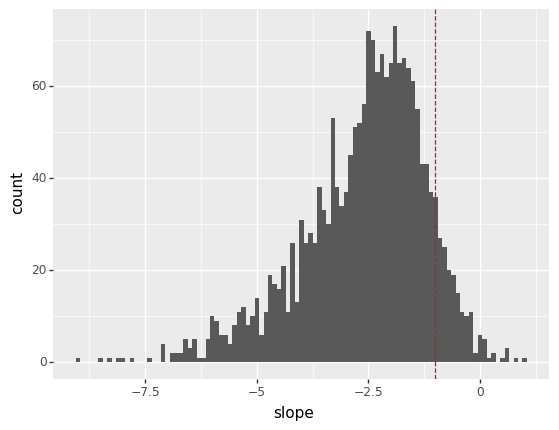

<ggplot: (8789541976689)>


array([ 0.86432802, -0.06797336, -0.45594216, -1.07803498, -2.02076238,
       -2.71938747, -3.5204922 , -4.98505838, -7.2787996 ])

In [124]:

print(p9.ggplot(df.query("Article == '675315'")) +  #178729
 p9.aes(x='slope') + 
 p9.geom_histogram(binwidth=0.1) +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed')
 )

np.quantile(df.query("Article == '178729'")['slope'],[0.99, 0.95, 0.90, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01])


Sampled article: 577862
norm
[('norm', 0.48411655594431824)]
{'norm': (-1.2148299824590516, 0.47007284901593244)}


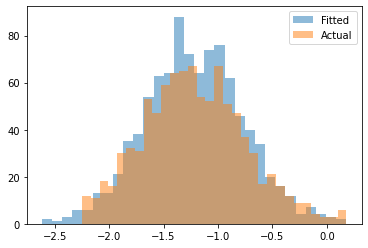

In [125]:
# determine best-fit distribution:
# https://www.hackdeploy.com/fitting-probability-distributions-with-python/
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
class Distribution(object):
    
    def __init__(self,dist_names_list = []):
        self.dist_names = ['norm'] #['norm','lognorm','t', 'loggamma', 'gamma', 'dweibull']
        self.dist_results = []
        self.params = {}
        
        self.DistributionName = ""
        self.PValue = 0
        self.Param = None
        
        self.isFitted = False
        
        
    def Fit(self, y):
        self.dist_results = []
        self.params = {}
        for dist_name in self.dist_names:
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y)
            
            self.params[dist_name] = param
            #Applying the Kolmogorov-Smirnov test
            D, p = scipy.stats.kstest(y, dist_name, args=param);
            self.dist_results.append((dist_name,p))
        #select the best fitted distribution
        sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
        #store the name of the best fit and its p value
        self.DistributionName = sel_dist
        self.PValue = p
        
        self.isFitted = True
        return self.DistributionName,self.PValue
    
    def Random(self, n = 1):
        if self.isFitted:
            dist_name = self.DistributionName
            param = self.params[dist_name]
            #initiate the scipy distribution
            dist = getattr(scipy.stats, dist_name)
            return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
        else:
            raise ValueError('Must first run the Fit method.')
            
    def Plot(self,y):
        x = self.Random(n=len(y))
        plt.hist(x, alpha=0.5, label='Fitted', bins=30)
        plt.hist(y, alpha=0.5, label='Actual', bins=30)
        plt.legend(loc='upper right')

from scipy.stats import norm
sample_article = df.query("(covid_flag == 'pre-covid')").Article.sample(1).iloc[0]
sample_dat = df.query("(Article == '"+sample_article+"') & (covid_flag == 'pre-covid')")

# trim the highest and lowest 1% to avoid fitting to problematic data.
if(1):
  sample_dat_quantiles = np.quantile(sample_dat.slope, [0.01, 0.99])
  trimmed_sample_dat = sample_dat[(sample_dat['slope'] > sample_dat_quantiles[0]) & (sample_dat['slope'] < sample_dat_quantiles[1])]
  r = trimmed_sample_dat.slope
else:
  r = sample_dat.slope

dst = Distribution()
dst.Fit(r)
dst.Plot(r)

print("Sampled article:",sample_article)
print(dst.DistributionName)
print(dst.dist_results)
print(dst.params)

In [126]:
np.mean(trimmed_sample_dat.slope< (-1))

0.679745493107105

In [ ]:
prob_fit_dict = {}
for sample_article in df.Article.unique():
  sample_dat = df.query("(Article == '"+sample_article+"') & (covid_flag == 'pre-covid')")

  try:
  # trim the highest and lowest 1% to avoid fitting to problematic data.
    if(1):
      sample_dat_quantiles = np.quantile(sample_dat.slope, [0.01, 0.99])
      trimmed_sample_dat = sample_dat[(sample_dat['slope'] > sample_dat_quantiles[0]) & (sample_dat['slope'] < sample_dat_quantiles[1])]
      r = trimmed_sample_dat.slope
    else:
      r = sample_dat.slope
    dst = Distribution()
    dst.Fit(r)

  #dst.Plot(r)
    prob_fit_dict[sample_article] = {'Data':r, 'Dist':dst}
  except:
    pass


{'norm': (-0.5734077479580318, 0.26173265845959887)}

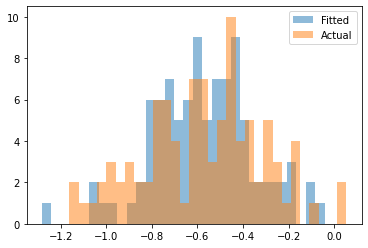

In [203]:
# view a random distribution fit
import random
sample_key = random.choice([x for x in prob_fit_dict.keys()])

prob_fit_dict[sample_key]['Dist'].Plot(prob_fit_dict[sample_key]['Data'])
prob_fit_dict[sample_key]['Dist'].params


## Clustering

[1543.5009, 620.4585506487983, 404.76396195560926, 308.7140493067369, 249.4462521660853, 210.94797367299657, 189.03203802984387, 170.6609738333827, 157.1785979935392, 147.52834548859607, 137.549742363131, 130.85982401135925, 123.47976017110224, 117.55359656349847, 113.03691790631453, 108.36709569087985, 104.55075080209284, 100.95876660519843, 97.62971003139695, 94.52808299553845, 91.2721030199371]


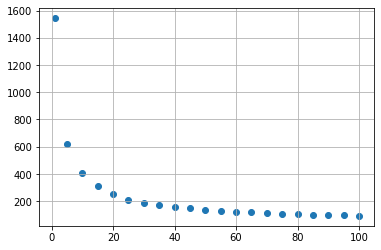

In [165]:
from sklearn.cluster import KMeans
import umap

def kmeans_diff_n(df,
                  n_clusters=[1],
                  max_iter=300,
                  tol=1e-04,
                  init='k-means++',
                  n_init=10,
                  algorithm='auto'):
    from sklearn.cluster import KMeans
    inertia_values = []
    for i in n_clusters:
        km = KMeans(n_clusters=i,
                    max_iter=max_iter,
                    tol=tol,
                    init=init,
                    n_init=n_init,
                    random_state=1,
                    algorithm=algorithm)
        km.fit_predict(df)
        inertia_values.append(km.inertia_)
    return inertia_values

df_wide = df.query("(covid_flag == 'pre-covid')").pivot(index="Site",
                   columns=["Article", "Sales_Unit"],
                   values="slope")

# drop column if all na's
df_wide = df_wide.dropna(axis=1, how='all')
# fill na with column medians
df_wide = df_wide.replace([np.inf, -np.inf], np.nan)
df_wide = df_wide.apply(lambda x: x.fillna(x.median()))
df_wide = df_wide.apply(lambda x: np.where(x < -10, -10, x))
df_wide = df_wide.apply(lambda x: np.where(x > 0, 0, x))

# find best number of clusters using elbow method:
embedding = umap.UMAP(n_neighbors=10, n_components=5).fit_transform(df_wide)

if (1):
    l_clusters = [
        x for x in np.array(range(1, min(101, df_wide.shape[0])))
        if x == 1 or x % 5 == 0
    ]
    kmeans_var_explained = kmeans_diff_n(embedding, l_clusters)
    print(kmeans_var_explained)

plt.scatter(x=l_clusters, y=kmeans_var_explained)
plt.grid()


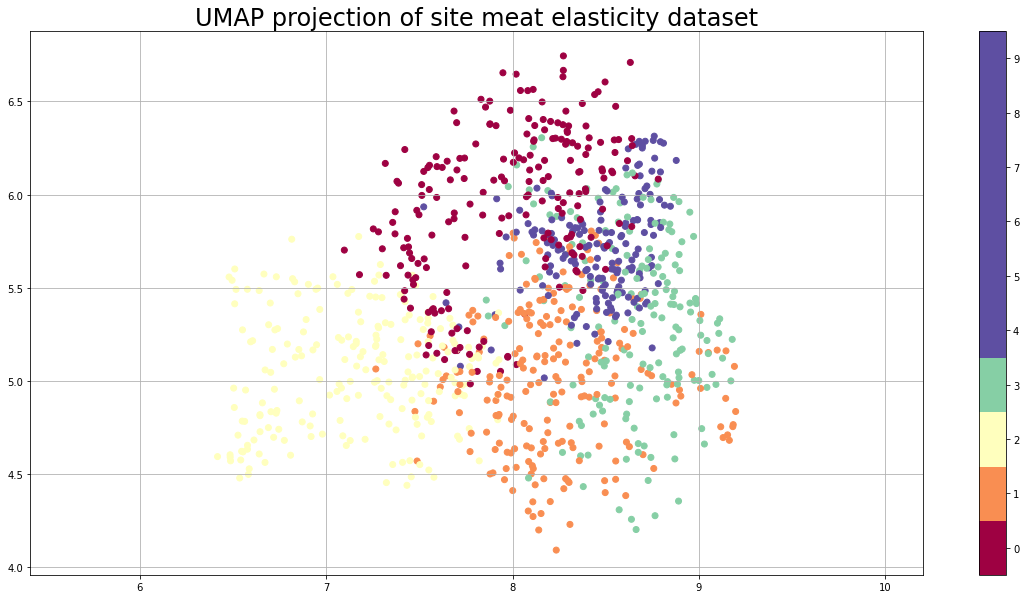

In [167]:

my_kmeans = KMeans(n_clusters=5, random_state=0).fit(embedding) #KMeans(n_clusters=5, random_state=0).fit(df_wide)

df_site_cluster_pair = pd.DataFrame({
    'site': list(df_wide.index),
    'cluster': list(my_kmeans.labels_)
})

plt.figure(figsize=(20,10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=my_kmeans.labels_, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of site meat elasticity dataset', fontsize=24);
plt.grid()


## Misc

In [114]:
df_wide.head(3)

Article,100198,100292,100295,100297,100299,100360,100361,100373,100384,100386,100394,100398,100419,100427,100449,100450,100453,100457,100462,100525,100528,100532,100540,100590,100593,100596,100617,100749,100758,100765,100944,100983,101035,101036,101043,101063,101067,101076,101094,101103,...,953307,953642,954383,954392,954486,954488,954544,954547,954551,955488,958752,958757,958759,958761,958763,958808,964093,964833,964834,964835,964836,964837,964838,964839,964840,964841,964842,967114,969723,969724,970381,970382,971384,971388,971389,971390,972203,972206,972210,972212
Sales_Unit,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,...,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,KG,EA,KG,EA,EA,KG,KG,KG,KG,KG,KG,KG,KG,EA,KG,KG,KG,KG,KG,KG,KG,KG,EA,EA,EA,EA
Site,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1004,-0.642868,-1.773756,-1.580887,-3.940057,-1.946788,-0.237407,0.0,-0.739886,-2.996132,-1.476187,-0.502797,0.0,-0.514997,-0.647098,-3.173371,-3.434532,-1.994391,-0.280282,-1.999126,-1.75104,-0.933887,0.0,-3.083784,-3.08557,-1.511658,-0.676669,-0.401271,-0.872315,-0.465338,-1.321868,-1.26106,-1.859526,-0.077295,-0.367532,-0.147918,-0.503033,-1.125661,-0.492342,-0.918365,-0.198156,...,-0.892409,-0.562142,-0.166936,-0.722797,-2.540215,-0.525374,-0.423689,-0.206576,-0.349818,0.0,0.0,-1.14334,-0.345181,-0.765062,-0.57389,-0.694046,-1.395797,-0.598477,-0.421299,0.0,-0.745145,-0.190751,-0.903694,-0.2357,-0.751621,-0.682463,-0.677075,-1.012240,-0.782914,-1.072564,-4.072541,0.0,-0.149155,0.0,-0.423044,-0.476314,-1.0648,-0.93421,-0.88576,-0.84204
1008,-0.642868,-1.773756,-1.580887,-3.940057,-1.946788,-0.237407,0.0,-0.739886,-2.996132,-1.476187,-0.502797,0.0,-0.514997,-0.647098,-3.173371,-3.434532,-1.994391,-0.280282,-1.999126,-1.75104,-0.933887,0.0,-3.083784,-3.08557,-1.511658,-0.676669,-0.401271,-0.872315,-0.465338,-1.321868,-1.26106,-1.859526,-0.077295,-0.367532,-0.147918,-0.503033,-1.125661,-0.492342,-0.918365,-0.198156,...,-0.892409,-0.562142,-0.166936,-0.722797,-2.540215,-0.525374,-0.423689,-0.206576,-0.349818,0.0,0.0,-1.14334,-0.345181,-0.765062,-0.57389,-0.519422,-1.420790,-0.598477,-0.421299,0.0,-0.745145,-0.190751,-0.903694,-0.2357,-0.751621,-0.682463,-0.677075,-0.372953,-0.782914,-1.072564,-4.072541,0.0,-0.149155,0.0,-0.423044,-0.476314,-1.0648,-0.93421,-0.88576,-0.84204
1030,-0.642868,-1.773756,-3.282609,-3.940057,-1.946788,-0.237407,0.0,-0.739886,-2.996132,-1.476187,-0.090369,0.0,-0.514997,-0.647098,-4.778401,-3.434532,-1.994391,-0.280282,-1.999126,-1.75104,-0.933887,0.0,-3.083784,-3.08557,-1.511658,-0.676669,-1.395823,-0.872315,-0.465338,-1.321868,-1.26106,-1.859526,-0.077295,-0.367532,-0.147918,-0.503033,-3.440190,-0.492342,-0.918365,-0.198156,...,-0.892409,-0.562142,-0.166936,-0.722797,-2.540215,-0.525374,-0.423689,-0.206576,-0.349818,0.0,0.0,-1.14334,-0.345181,-0.765062,-0.57389,-0.445274,-0.977806,-0.598477,-0.421299,0.0,-0.745145,-0.190751,-0.903694,-0.2357,-0.751621,-0.682463,-0.677075,-0.985171,-0.782914,-1.072564,-4.072541,0.0,-0.149155,0.0,-0.423044,-0.476314,-1.0648,-0.93421,-0.88576,-0.84204


In [68]:
print(df.shape)
df.head(3)

(661122, 22)


,SalesOrg,Site,Article,Article_Description,Category_Description,SubCategory_Description,Sales_Unit,covid_flag,mean_x,mean_y,corr_xy,sd_x,sd_y,cnt_overs,cnt_unders,perc_unders,Sales_ExclTax,Sales_Qty_SUoM,ASP,slope,y_intercept,elasticity_score
0,1005,5659,100198,Gravy Beef kg 5,MEAT,BEEF,KG,pre-covid,-0.000081,0.004342,-0.114330,0.085111,0.831534,46,51,0.078101,48585.59,2968.418,16.367503,-1.116996,0.004251,5684.322949
1,1005,7220,100198,Gravy Beef kg 5,MEAT,BEEF,KG,covid (Other),-0.011265,0.015787,-0.087092,0.130761,0.780409,18,21,0.198113,4498.39,265.151,16.965390,-0.519784,0.009932,-2160.201030
2,1005,7018,100198,Gravy Beef kg 5,MEAT,BEEF,KG,pre-covid,0.003282,-0.018014,-0.197631,0.174594,0.763973,90,80,0.197044,14119.39,921.987,15.314088,-0.864774,-0.015176,-1909.310957


In [ ]:
# look at distribution of model slopes. Change in qty sold given change in price.
(p9.ggplot(df) + 
 p9.aes(x='slope') + 
 p9.geom_histogram(binwidth=0.1) +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.labs(title=str(round(np.mean(df.slope < -1)*100,1))+"% of records elastic")
 )


/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


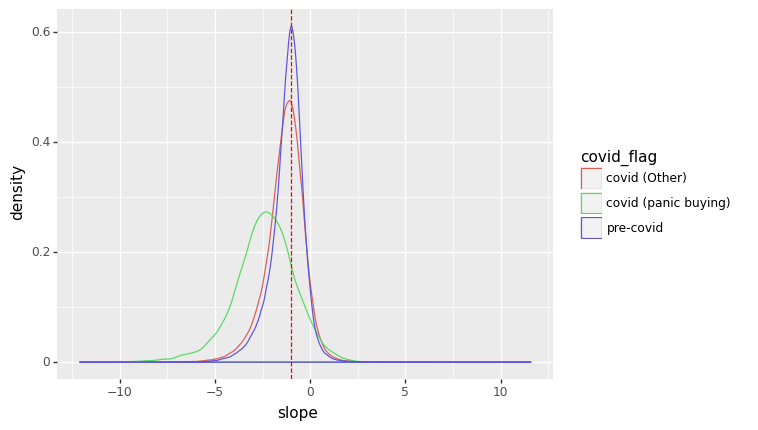

<ggplot: (-9223363288988277090)>

In [ ]:
# look at distribution of model slopes by covid period. Overall.
(p9.ggplot(df) + 
 p9.aes(x='slope', color='covid_flag') + 
 p9.geom_density() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed')
 )


In [ ]:
# look at distribution of model slopes by covid period. Per article
covid_compare_article = df.pivot_table(index=['Article','Article_Description',	'Category_Description',	'SubCategory_Description',	'Sales_Unit'], columns='covid_flag', values='slope').dropna().reset_index()
covid_compare_article['pre_preCovidSlope_less_panicBuySlope'] = covid_compare_article['pre-covid']-covid_compare_article['covid (panic buying)']
covid_compare_article['pre_preCovidSlope_less_covidOtherSlope'] = covid_compare_article['pre-covid']-covid_compare_article['covid (Other)']

print(p9.ggplot(covid_compare_article) + 
 p9.aes(x='pre_preCovidSlope_less_panicBuySlope') + 
 p9.geom_histogram(binwidth=0.1) +
 p9.geom_vline(xintercept= 0, color='red', linetype='dashed') +
 p9.labs(title="pre_preCovidSlope_less_panicBuySlope")
 )

print(p9.ggplot(covid_compare_article) + 
 p9.aes(x='pre_preCovidSlope_less_covidOtherSlope') + 
 p9.geom_histogram(binwidth=0.1) +
 p9.geom_vline(xintercept= 0, color='red', linetype='dashed') +
 p9.labs(title="pre_preCovidSlope_less_covidOtherSlope")
 )

In [ ]:
# look at distribution of model slopes. Change in qty sold given change in price.
(p9.ggplot(df) + 
 p9.aes(x='SubCategory_Description', y='slope', color='covid_flag') + 
 #p9.geom_histogram(binwidth=0.1) +
 p9.geom_boxplot() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.coord_flip() 
 )


In [ ]:
# look at slopes against sales $s. The idea being that we should focus more attention of more popular products.
(p9.ggplot(df) + 
 p9.aes(x='slope', y='Sales_ExclTax') + 
 p9.geom_point() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.scale_y_continuous(labels=currency_format(big_mark=',', digits=0))
 )


In [ ]:
# Check if we are often moving prices on inelastic articles.
# look at price variations relative to slopes.

(p9.ggplot(df) + 
 p9.aes(x='slope', y='sd_x') +#, color='Sales_ExclTax') + 
 p9.geom_point() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.geom_hline(yintercept= np.median(df.sd_x), color='red', linetype='dashed') #+
 #p9.scale_color_gradient2(low='White', mid='Gray', high='Red', midpoint=np.median(df.Sales_ExclTax))
 )


In [ ]:
df.query("slope > -1").sort_values('Sales_ExclTax', ascending=False)

In [ ]:
print(p9.ggplot(df) + 
 p9.aes(x='slope', y='sd_x', color='elasticity_score') + 
 p9.geom_point() +
 p9.geom_vline(xintercept= -1, color='red', linetype='dashed') +
 p9.geom_hline(yintercept= np.median(df.sd_x), color='red', linetype='dashed') +
 p9.scale_color_gradient2(low='Red', mid='White', high='Green', midpoint=np.median(df.elasticity_score))
 )

print(p9.ggplot(df) + 
 p9.aes(x='elasticity_score', y='sd_x') + 
 p9.geom_point() +
 p9.geom_vline(xintercept= np.median(df.elasticity_score), color='red', linetype='dashed') +
 p9.geom_hline(yintercept= np.median(df.sd_x), color='red', linetype='dashed')
 )
